In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt

In [161]:
sns.set_style('whitegrid')

In [74]:
tasks = pd.read_csv("../datasets/GlobusComputeDataset-v1-tasks.csv")

task_uuid                    0
function_uuid                0
endpoint_uuid                0
anonymized_user_uuid         0
argument_size           245567
received                394993
waiting_for_nodes       268297
waiting_for_launch      289574
execution_start         244541
execution_end           244532
result_received          95725
dtype: int64

In [80]:
tasks = tasks.dropna(subset=['received', 'result_received'])

In [3]:
functions = pd.read_csv("../datasets/GlobusComputeDataset-v1-functions.csv")

## Latency histogram

Here we are looking at what proportion of the tasks on the Globus platform present high latencies. 
This can be used as an indicator that users usually run delayable tasks on the platform.

In [122]:
task_latencies = pd.DataFrame({"Task latency (seconds)": (tasks["result_received"] - tasks["received"]) / 1000000000})

In [123]:
total_tasks = task_latencies.shape[0]

In [126]:
latencies_v = task_latencies['Task latency (seconds)']

Text(0.5, 0, 'Task latencies from received to response received (seconds)')

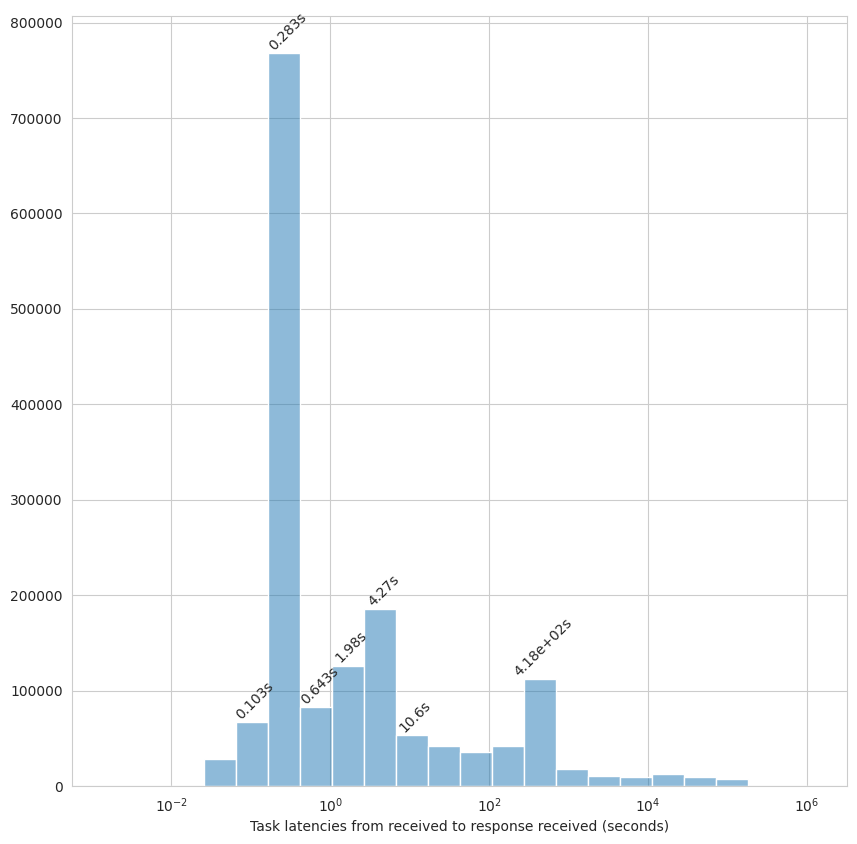

In [165]:
plt.figure(figsize=(10, 10))

ax = sns.histplot(
    data=task_latencies,
    bins=math.ceil(math.log2(total_tasks) + 1),
    log_scale=True
)

ax.get_legend().remove()

for rect in ax.patches:
    width, height = rect.get_width(), rect.get_height()
    x = rect.get_x()

    if height < 50000: continue
    
    bin_mask = (latencies_v >= x) & (latencies_v < x + width)
    bin_mean = latencies_v[bin_mask].mean().mean()
    
    plt.text(x + width/2., height, f"{bin_mean:.03}s", ha='center', va='bottom', rotation=45)

plt.ylabel('')
plt.xlabel('Task latencies from received to response received (seconds)')

Text(0.5, 0, 'Task latencies from received to response received (seconds)')

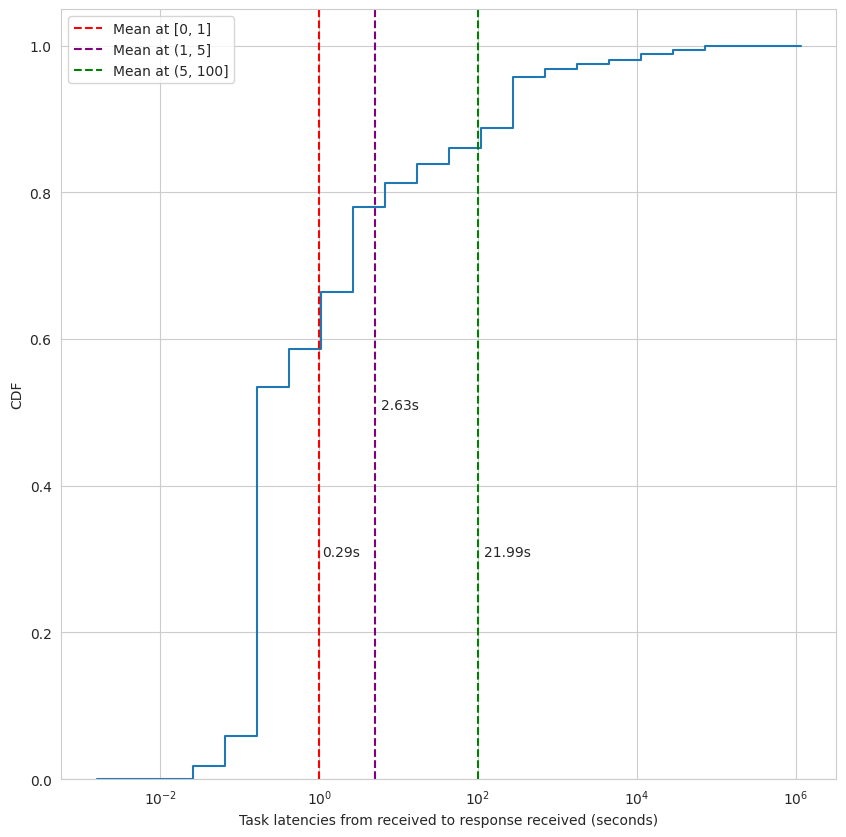

In [164]:
plt.figure(figsize=(10, 10))

ax = sns.histplot(
    data=task_latencies,
    bins=math.ceil(math.log2(total_tasks) + 1),
    log_scale=True, element="step", fill=False,
    cumulative=True, stat="density", common_norm=False
)

ax.get_legend().remove()

mean_0_1 = latencies_v[(latencies_v <= 1) & (latencies_v >= 0)].mean()
mean_0_2 = latencies_v[(latencies_v > 1) & (latencies_v <= 5)].mean()
mean_0_3 = latencies_v[(latencies_v > 5) & (latencies_v <= 100)].mean()

plt.axvline(x=1, color='r', linestyle='--', label=f'Mean at [0, 1]')
plt.text(1.1, 0.3, f'{mean_0_1:.2f}s', ha="left", va="bottom")

plt.axvline(x=5, color='purple', linestyle='--', label=f'Mean at (1, 5]')
plt.text(6, 0.5, f'{mean_0_2:.2f}s', ha="left", va="bottom")

plt.axvline(x=100, color='g', linestyle='--', label=f'Mean at (5, 100]')
plt.text(120, 0.3, f'{mean_0_3:.2f}s', ha="left", va="bottom")

plt.legend()

plt.ylabel('CDF')
plt.xlabel('Task latencies from received to response received (seconds)')

In [133]:
less_than_1_second = latencies_v[latencies_v < 1]
more_than_1_second = latencies_v[latencies_v >= 1]
more_than_2_seconds = latencies_v[latencies_v >= 2]
more_than_5_seconds = latencies_v[latencies_v >= 5]

In [134]:
pct_less_1 = less_than_1_second.shape[0] / total_tasks
pct_more_1 = more_than_1_second.shape[0] / total_tasks
pct_more_2 = more_than_2_seconds.shape[0] / total_tasks
pct_more_5 = more_than_5_seconds.shape[0] / total_tasks

Text(0, 0.5, 'Percentage')

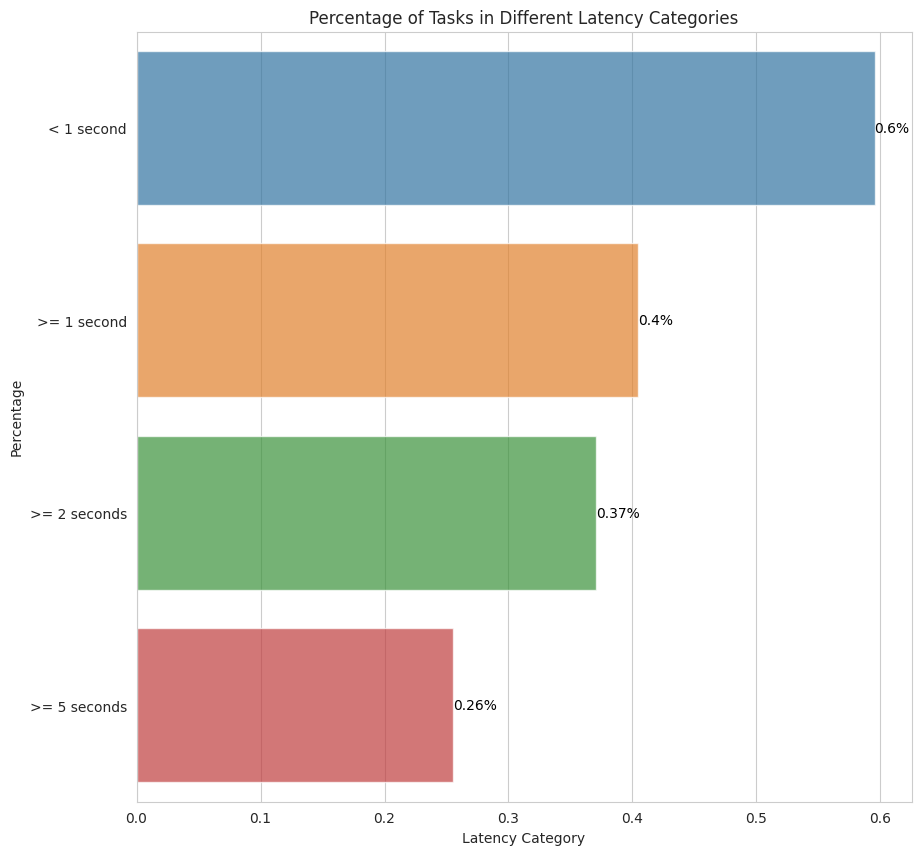

In [162]:
plt.figure(figsize=(10, 10))

categories = pd.DataFrame({
    'Percentage': [pct_less_1, pct_more_1, pct_more_2, pct_more_5], 
    'Latency category': ['< 1 second', '>= 1 second', '>= 2 seconds', '>= 5 seconds']
})

bar_colors = ['#FF6347', '#4682B4', '#32CD32', '#FFD700']

sns.barplot(categories, x='Percentage', y='Latency category', hue='Latency category', alpha=.7, orient='y')

for index, row in categories.iterrows():
    pct = row['Percentage']
    plt.text(pct, index, f'{pct:.2}%', color='black', va="center")

plt.title('Percentage of Tasks in Different Latency Categories')
plt.xlabel('Latency Category')
plt.ylabel('Percentage')